This notebook demonstrates fairness influence functions on health-insurance prediction task. For details, see example 1.1 in https://arxiv.org/pdf/2206.00667.pdf

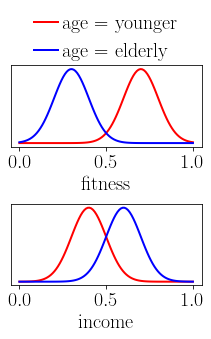

In [4]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = True


import pandas as pd


sigma = 0.1
np.random.seed(10)


mu_income_high = 0.6
mu_income_low = 0.4
mu_health_high = 0.7
mu_health_low = 0.3
samples = 10000

# define distribution
income_high_dist = norm(loc = mu_income_high, scale = sigma)
income_low_dist = norm(loc = mu_income_low, scale = sigma)

# generate samples from distribution
income_high_samples = np.random.normal(mu_income_high, sigma, int(samples/2))
income_low_samples = np.random.normal(mu_income_low, sigma, int(samples/2))



# define distribution
health_high_dist = norm(loc = mu_health_high, scale = sigma)
health_low_dist = norm(loc = mu_health_low, scale = sigma)

# generate samples from distribution
health_high_samples = np.random.normal(mu_health_high, sigma, int(samples/2))
health_low_samples = np.random.normal(mu_health_low, sigma, int(samples/2))

x = np.linspace(0,1, 100)

fontsize = 24
labelsize = 20
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(3, 4))
ax[1].plot(x, income_low_dist.pdf(x),'r-', lw=2,  label='age = younger')
ax[1].plot(x, income_high_dist.pdf(x),'b-', lw=2,  label='age = elderly')
ax[1].set_xlabel("income", fontsize=labelsize)
ax[1].set_yticks([])
ax[1].tick_params(axis='x', labelsize=labelsize)

ax[0].plot(x, health_high_dist.pdf(x),'r-', lw=2,  label='age = younger')
ax[0].plot(x, health_low_dist.pdf(x),'b-', lw=2, label='age = elderly')
ax[0].set_xlabel("fitness", fontsize=labelsize)
ax[0].set_yticks([])
ax[0].tick_params(axis='x', labelsize=labelsize)


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines[:2], labels[:2], loc='upper center', ncol=1, bbox_to_anchor= (0.505, 1.2), handlelength=1.2, handletextpad=0.2, columnspacing=None, frameon=False, fontsize=labelsize)
plt.tight_layout()
plt.show()

In [5]:
# # target 
income = np.concatenate([income_low_samples, income_high_samples])
health = np.concatenate([health_high_samples, health_low_samples])
age = np.concatenate([np.zeros(len(income_low_samples), dtype=int), np.ones(len(income_high_samples), dtype=int)])

# # define target as sum of income and health
target = []
for i in range(samples):
    if(health[i] + income[i] > 1):
        target.append(1)
    else:
        target.append(0)
target = np.array(target)
df = pd.DataFrame(data=np.array(list(zip(income, age, health, target))), columns=['income', 'age', 'fitness', 'target'])
df

,income,age,fitness,target
0,0.462325,0.0,0.481305,0.0
1,0.405066,0.0,0.622414,1.0
2,0.439972,0.0,0.690747,1.0
3,0.178555,0.0,0.658828,0.0
4,0.553709,0.0,0.649325,1.0
...,...,...,...,...
9995,0.715352,1.0,0.230937,0.0
9996,0.528095,1.0,0.243940,0.0
9997,0.455745,1.0,0.382715,0.0
9998,0.638839,1.0,0.261416,0.0


In [6]:
# An example decision tree
class DT_synthetic():
    def __init__(self, affirmative_action=False):
        self.affirmative_action = affirmative_action
        pass

    def predict(self, X):
        y = []
        income_threshold = 0.69
        if(self.affirmative_action):
            income_threshold = 0.555
        for x in X:
            income, age, fitness = x[0], x[1], x[2]
            if(fitness > 0.61):
                if(income > 0.29):
                    y.append(1)
                else:
                    y.append(0)
            else:
                if(income > income_threshold):
                    y.append(1)
                else:
                    y.append(0)
        return np.array(y)

In [12]:
# !pip install fairxplainer
!pip show fairxplainer

import sys
sys.path.append("../") # without pip install

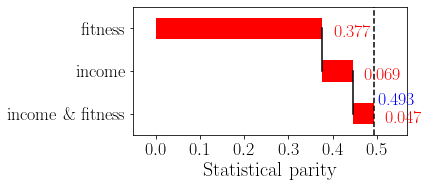

Exact statistical parity: 0.529


In [13]:
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer.fair_explainer import FairXplainer


affirmative_action = False # set to True to see the effect of affirmative action
clf = DT_synthetic(affirmative_action=affirmative_action)

X = df.drop(['target'], axis=1)
y = df['target']

verbose = False
fairXplainer = FairXplainer(classifier=clf, dataset=X, sensitive_features=['age'], verbose=verbose)
fairXplainer.compute(approach="hdmr", spline_intervals=20, verbose=verbose)

explanation_result = fairXplainer.get_top_k_weights(k=10)

plt = fif_plot(explanation_result, draw_waterfall=True, labelsize=18, fontsize=20, figure_size=(6, 2.7), title="", text_x_pad=0.05, text_y_pad=0.2, result_y_location=0.6, result_x_pad=0.02,
           x_label=r"Statistical parity", delete_zero_weights=True)
plt.show()
print("Exact statistical parity:", fairXplainer.statistical_parity_dataset())


In [9]:
# Accuracy calculation
from sklearn.metrics import classification_report
print(classification_report(y, clf.predict(X.values)))

              precision    recall  f1-score   support

         0.0       0.79      0.89      0.84      4945
         1.0       0.88      0.77      0.82      5055

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

